# Red Team: Adversarial Attack

Author: Jessica Sihite<br>
Student ID: 1275588<br>
See red-team/README.md for detailed documentation.

**Notebook set-up.**

In [ ]:
# Standard library imports
import os
import sys
import warnings
from pathlib import Path
from typing import Tuple, Dict, List, Optional, Union
import joblib

# Third-party imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive
drive.mount('/content/drive')

# Machine learning imports
from sklearn.svm import OneClassSVM

# Visualisation imports
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Verify paths
os.chdir('/content/drive/MyDrive/COMP90073-Assignment2')
PROJECT_PATH = Path(os.getcwd())
DATA_DIR = PROJECT_PATH / 'data'
TEMPLATE_DIR = PROJECT_PATH / 'template_code'
RESULTS_DIR = PROJECT_PATH / 'results'

# Load pre-trained model using code from load.py
sys.path.append(str(TEMPLATE_DIR))
import model as model_module

# Device configuration
DEVICE = torch.device('cuda')
dtype = torch.float32
RANDOM_SEED = 42

weights = torch.load(DATA_DIR /'model_chkpt.pt', map_location=DEVICE)
pretrained_model = model_module.Averager(1, 10, 0.125)
pretrained_model.model.load_state_dict(weights)
pretrained_model.to(DEVICE)
pretrained_model.eval()

# Set random seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load and visualise data.**

Total samples: 10000
Image dimensions: 32x32
Value range: [-2.010, 2.170]
Number of classes: 10

Class Distribution:
  Class 0 (airplane  ): 1000 samples (10.0%)
  Class 1 (automobile): 1000 samples (10.0%)
  Class 2 (bird      ): 1000 samples (10.0%)
  Class 3 (cat       ): 1000 samples (10.0%)
  Class 4 (deer      ): 1000 samples (10.0%)
  Class 5 (dog       ): 1000 samples (10.0%)
  Class 6 (frog      ): 1000 samples (10.0%)
  Class 7 (horse     ): 1000 samples (10.0%)
  Class 8 (ship      ): 1000 samples (10.0%)
  Class 9 (truck     ): 1000 samples (10.0%)

Model performance on clean data: 
Clean Accuracy: 93.32% (9332/10000)


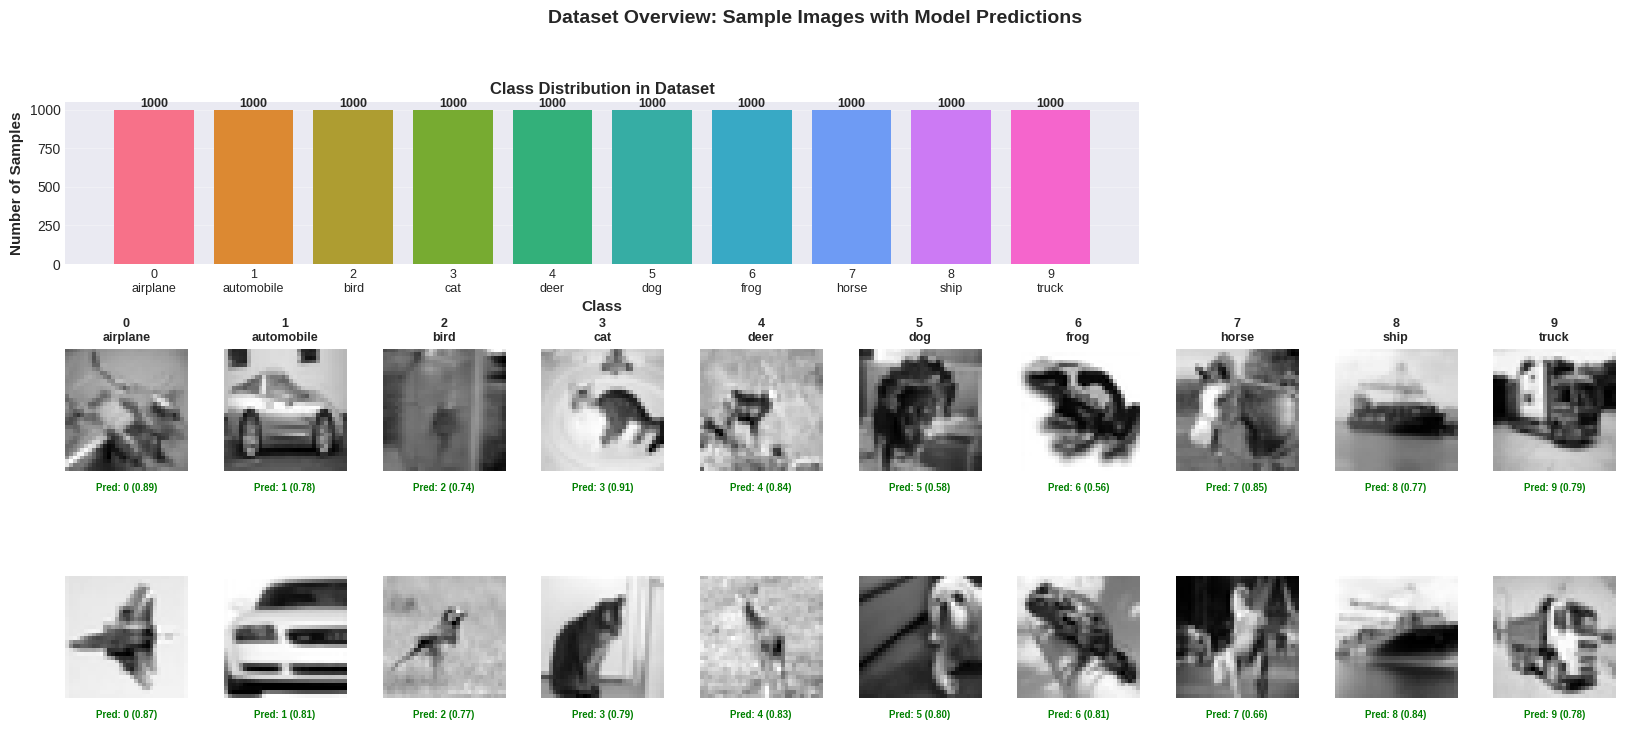

In [ ]:
# Load dataset
dataset = torch.load(DATA_DIR / 'dataset.pt', weights_only = False)

all_images = []
all_labels = []
for img, label in dataset:
    all_images.append(img)
    all_labels.append(label)
images = torch.stack(all_images).to(DEVICE)
labels = torch.tensor(all_labels).to(DEVICE)

# Dataset statistics
print(f"Total samples: {len(images)}")
print(f"Image dimensions: {images.shape[2]}x{images.shape[3]}")
print(f"Value range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Number of classes: {len(torch.unique(labels))}")

# Class distribution
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
unique_labels, counts = torch.unique(labels, return_counts=True)

print("\nClass Distribution:")
for label, count in zip(unique_labels, counts):
    print(f"  Class {label} ({class_names[label]:10s}): {count:4d} samples ({100*count/len(labels):.1f}%)")

# Test model accuracy on clean data
print("\nModel performance on clean data: ")

pretrained_model.eval()
with torch.no_grad():
    batch_size = 512
    correct = 0
    total = 0

    for i in range(0, len(images), batch_size):
        batch_images = images[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        outputs = pretrained_model(batch_images)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == batch_labels).sum().item()
        total += batch_labels.size(0)

    accuracy = 100 * correct / total
    print(f"Clean Accuracy: {accuracy:.2f}% ({correct}/{total})")

# Visualizations
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(3, 10, figure=fig, hspace=0.4, wspace=0.3)

# 1. Class distribution
ax1 = fig.add_subplot(gs[0, :7])
bars = ax1.bar(range(10), counts.cpu().numpy(), color=sns.color_palette("husl", 10))
ax1.set_xlabel('Class', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax1.set_title('Class Distribution in Dataset', fontsize=12, fontweight='bold')
ax1.set_xticks(range(10))
ax1.set_xticklabels([f"{i}\n{class_names[i]}" for i in range(10)], fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Sample images from each class (2 rows x 10 columns)
for class_idx in range(10):
    # Get indices for this class
    class_indices = (labels == class_idx).nonzero(as_tuple=True)[0]

    # Select 2 random samples
    sample_indices = class_indices[torch.randperm(len(class_indices))[:2]]

    for row, idx in enumerate(sample_indices):
        ax = fig.add_subplot(gs[row + 1, class_idx])
        img = images[idx].cpu().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')

        # Add class label on first row
        if row == 0:
            ax.set_title(f"{class_idx}\n{class_names[class_idx]}",
                        fontsize=9, fontweight='bold')

        # Add prediction
        with torch.no_grad():
            output = pretrained_model(images[idx:idx+1])
            pred = output.argmax(dim=1).item()
            conf = F.softmax(output, dim=1).max().item()

        # Color code: green if correct, red if wrong
        color = 'green' if pred == class_idx else 'red'
        ax.text(0.5, -0.1, f"Pred: {pred} ({conf:.2f})",
               transform=ax.transAxes, ha='center', va='top',
               fontsize=7, color=color, fontweight='bold')

plt.suptitle('Dataset Overview: Sample Images with Model Predictions',
            fontsize=14, fontweight='bold', y=0.995)
plt.savefig('dataset_overview.png', dpi=300, bbox_inches='tight')
plt.show()

**Create test subset (every 10-th sample in the dataset) for adversarial attack.**

In [ ]:
# Create test subset (every 10th sample)
attack_indices = list(range(0, len(images), 10))
test_images_clean = images[attack_indices].clone()
test_labels = labels[attack_indices].clone()

print(f"Original dataset: {len(images)} samples")
print(f"Test subset (every 10th): {len(test_images_clean)} samples")
print(f"Percentage: {100 * len(test_images_clean) / len(images):.1f}%")

# Verify class distribution maintained
unique_test, counts_test = torch.unique(test_labels, return_counts=True)
print("\nTest subset class distribution:")
for label, count in zip(unique_test, counts_test):
    print(f"  Class {label} ({class_names[label]:10s}): {count:3d} samples")

# Verify clean accuracy on test subset
print("\nBaseline accuracy on test subset:")
with torch.no_grad():
    outputs = pretrained_model(test_images_clean)
    predictions = outputs.argmax(dim=1)
    correct = (predictions == test_labels).sum().item()
    accuracy = 100 * correct / len(test_labels)
    print(f"Clean accuracy: {accuracy:.2f}% ({correct}/{len(test_labels)})")

# Save clean test dataset for later comparison
test_dataset_clean = {
    'images': test_images_clean.cpu(),
    'labels': test_labels.cpu(),
    'indices': attack_indices,
    'description': 'Every 10th sample from dataset.pt for adversarial testing'
}

torch.save(test_dataset_clean, DATA_DIR/'test_subset_clean.pt')

# Placeholder for adversarial examples to store adversarial examples at different step sizes
adversarial_results = {
    'clean_images': test_images_clean.cpu(),
    'true_labels': test_labels.cpu(),
    'indices': attack_indices,
    'step_sizes': [],  # Will populate with tested step sizes
    'untargeted': {
        # Will store adversarial images, success flags, l2 norms, iterations
    },
    'targeted': {
        # Will store adversarial images, success flags, l2 norms, iterations
    }
}

Original dataset: 10000 samples
Test subset (every 10th): 1000 samples
Percentage: 10.0%

Test subset class distribution:
  Class 0 (airplane  ):  87 samples
  Class 1 (automobile): 100 samples
  Class 2 (bird      ): 108 samples
  Class 3 (cat       ): 107 samples
  Class 4 (deer      ):  95 samples
  Class 5 (dog       ):  95 samples
  Class 6 (frog      ): 100 samples
  Class 7 (horse     ): 102 samples
  Class 8 (ship      ): 102 samples
  Class 9 (truck     ): 104 samples

Baseline accuracy on test subset:
Clean accuracy: 92.10% (921/1000)


**Define VAE class (used in epsilon tuning and defence testing).**

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=1024, latent_dim=16):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, input_dim)

    def encode(self, x):
        h = torch.relu(self.bn1(self.fc1(x)))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.bn3(self.fc3(z)))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

**PGD attack implementation**.

In [ ]:
class StandardPGD:
    def __init__(self, model, device, max_iters=100, epsilon=2.0):
        """
        Standard PGD attack implementation.

        Args:
            model: Target classifier model
            device: torch device (cuda)
            max_iters: Maximum number of iterations (capped at 100)
            epsilon: Maximum L2 perturbation constraint
        """
        self.model = model
        self.device = device
        self.max_iters = max_iters
        self.epsilon = epsilon

    def compute_l2_norm(self, x_adv, x_orig):
        """Calculate L2 norm using sum, power, and sqrt operations."""
        diff = x_adv - x_orig
        squared = torch.pow(diff, 2)
        summed = torch.sum(squared)
        l2 = torch.sqrt(summed)
        return l2.item()

    def attack_untargeted(self, x, y_true, step_size):
        """
        Untargeted PGD attack: forces any misclassification.

        Args:
            x: Input image
            y_true: True label
            step_size: Step size for gradient updates

        Returns:
            x_adv: Adversarial image
            success: Whether attack succeeded
            iterations: Number of iterations used
            l2_norm: L2 distance from original
        """
        x_adv = x.clone().detach()
        x_orig = x.clone().detach()
        loss_history = []

        for iteration in range(self.max_iters):
            x_adv.requires_grad_(True)

            logits = self.model(x_adv)

            # Untargeted: maximize cross-entropy loss to fool classifier
            loss = F.cross_entropy(logits, y_true)
            loss_history.append(loss.item())
            loss.backward()

            with torch.no_grad():
                grad = x_adv.grad
                grad_norm = grad.view(-1).norm(p=2) + 1e-10

                # Gradient ascent (maximize loss)
                x_adv = x_adv + step_size * (grad / grad_norm)

                # Project to epsilon ball
                delta = x_adv - x_orig
                delta_norm = torch.sqrt(torch.sum(torch.pow(delta, 2)))
                if delta_norm > self.epsilon:
                    delta = delta * (self.epsilon / delta_norm)
                x_adv = x_orig + delta
                x_adv = torch.clamp(x_adv, 0.0, 1.0)

            # Early stopping check every 20 iterations
            if (iteration + 1) % 20 == 0:
                with torch.no_grad():
                    pred = self.model(x_adv).argmax(dim=1)
                    if pred.item() != y_true.item():
                        l2_norm = self.compute_l2_norm(x_adv, x_orig)
                        return x_adv.detach(), True, iteration + 1, l2_norm, loss_history

        # Final evaluation
        with torch.no_grad():
            pred = self.model(x_adv).argmax(dim=1)
            success = (pred.item() != y_true.item())
            l2_norm = self.compute_l2_norm(x_adv, x_orig)

        return x_adv.detach(), success, self.max_iters, l2_norm, loss_history

    def attack_targeted(self, x, y_true, target_class, step_size):
        """
        Targeted PGD attack: forces prediction to specific target class.

        Args:
            x: Input image
            y_true: True label
            target_class: Target class to force prediction to (Class 5)
            step_size: Step size for gradient updates

        Returns:
            x_adv: Adversarial image
            success: Whether attack succeeded
            iterations: Number of iterations used
            l2_norm: L2 distance from original
        """
        x_adv = x.clone().detach()
        x_orig = x.clone().detach()
        target = torch.tensor([target_class], device=self.device)
        loss_history = []

        for iteration in range(self.max_iters):
            x_adv.requires_grad_(True)

            logits = self.model(x_adv)

            # Targeted: minimise cross-entropy loss on target class
            loss = F.cross_entropy(logits, target)
            loss_history.append(loss.item())
            loss.backward()

            with torch.no_grad():
                grad = x_adv.grad
                grad_norm = grad.view(-1).norm(p=2) + 1e-10

                # Gradient descent (minimise loss)
                x_adv = x_adv - step_size * (grad / grad_norm)

                # Project to epsilon ball
                delta = x_adv - x_orig
                delta_norm = torch.sqrt(torch.sum(torch.pow(delta, 2)))
                if delta_norm > self.epsilon:
                    delta = delta * (self.epsilon / delta_norm)
                x_adv = x_orig + delta
                x_adv = torch.clamp(x_adv, 0.0, 1.0)

            # Early stopping check every 20 iterations
            if (iteration + 1) % 20 == 0:
                with torch.no_grad():
                    pred = self.model(x_adv).argmax(dim=1)
                    if pred.item() == target_class:
                        l2_norm = self.compute_l2_norm(x_adv, x_orig)
                        return x_adv.detach(), True, iteration + 1, l2_norm, loss_history

        # Final evaluation
        with torch.no_grad():
            pred = self.model(x_adv).argmax(dim=1)
            success = (pred.item() == target_class)
            l2_norm = self.compute_l2_norm(x_adv, x_orig)

        return x_adv.detach(), success, self.max_iters, l2_norm, loss_history


def run_standard_attack_experiment(test_images, test_labels, model, device, step_sizes, target_class=5, epsilon=2.0):
    """
    Run standard PGD attack experiments across multiple step sizes.

    Args:
        test_images: Test images tensor
        test_labels: Test labels tensor
        model: Target model
        device: torch device
        step_sizes: Array of step sizes to test
        target_class: Target class for targeted attacks
        epsilon: L2 perturbation budget (default value = 2.0)

    Returns:
        results: Dictionary containing attack results for all step sizes
    """
    model.eval()
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)

    attacker = StandardPGD(
        model=model,
        device=device,
        max_iters=100,
        epsilon=epsilon
    )

    results = {
        'step_sizes': step_sizes,
        'untargeted': {},
        'targeted': {},
        'clean_images': test_images.cpu(),
        'true_labels': test_labels.cpu()
    }

    print("=" * 70)
    print("Standard PGD Attack")
    print(f"Test samples: {len(test_images)} (every 10th sample from dataset)")
    print(f"Step size range: {step_sizes[0]:.0e} to {step_sizes[-1]:.0e}")
    print(f"Number of step sizes: {len(step_sizes)}")
    print(f"Target class (targeted attacks): {target_class}")
    print(f"Epsilon constraint (L2): {attacker.epsilon}")
    print("=" * 70)

    for step_size in tqdm(step_sizes, desc="Step sizes"):
        untargeted_advs, untargeted_success, untargeted_l2, untargeted_iters = [], [], [], []
        untargeted_loss_histories = []
        targeted_advs, targeted_success, targeted_l2, targeted_iters = [], [], [], []
        targeted_loss_histories = []

        for idx in range(len(test_images)):
            x = test_images[idx:idx+1]
            y = test_labels[idx:idx+1]

            # Untargeted attack
            x_adv_unt, success_unt, iters_unt, l2_unt, loss_hist_unt = attacker.attack_untargeted(x, y, step_size)
            untargeted_advs.append(x_adv_unt.cpu())
            untargeted_success.append(success_unt)
            untargeted_l2.append(l2_unt)
            untargeted_iters.append(iters_unt)
            untargeted_loss_histories.append(loss_hist_unt)

            # Targeted attack
            x_adv_tgt, success_tgt, iters_tgt, l2_tgt, loss_hist_tgt = attacker.attack_targeted(x, y, target_class, step_size)
            targeted_advs.append(x_adv_tgt.cpu())
            targeted_success.append(success_tgt)
            targeted_l2.append(l2_tgt)
            targeted_iters.append(iters_tgt)
            targeted_loss_histories.append(loss_hist_tgt)

        # Store results for this step size
        results['untargeted'][step_size] = {
            'adversarial_images': torch.cat(untargeted_advs, dim=0),
            'success': untargeted_success,
            'l2_norms': untargeted_l2,
            'iterations': untargeted_iters,
            'loss_histories': untargeted_loss_histories,
            'success_rate': sum(untargeted_success) / len(untargeted_success)
        }

        results['targeted'][step_size] = {
            'adversarial_images': torch.cat(targeted_advs, dim=0),
            'success': targeted_success,
            'l2_norms': targeted_l2,
            'iterations': targeted_iters,
            'loss_histories': targeted_loss_histories,
            'success_rate': sum(targeted_success) / len(targeted_success)
        }

        print(f"Step size {step_size:.0e}: Untargeted {results['untargeted'][step_size]['success_rate']:.1%}, "
              f"Targeted {results['targeted'][step_size]['success_rate']:.1%}")

    return results

# Epsilon tuning (test multiple epsilon candidates)
print("\n" + "=" * 70)
print(f"\nEpsilon tuning\n")
print("=" * 70)

# Load defense models
vae_checkpoint = torch.load(DATA_DIR / 'vae_anomaly_detector.pt', weights_only=False, map_location=DEVICE)
vae = VAE(input_dim = vae_checkpoint['input_dim'],
          latent_dim = 16)
vae.load_state_dict(vae_checkpoint['model_state_dict'])
vae.to(DEVICE)
vae.eval()
vae_threshold = vae_checkpoint['threshold']

maha_checkpoint = torch.load(DATA_DIR / 'mahalanobis_ood_detector.pt', weights_only=False, map_location=DEVICE)
class_means = torch.stack([maha_checkpoint['class_means'][c].to(DEVICE) for c in range(10)])
class_cov_invs = [maha_checkpoint['class_cov_invs'][c].to(DEVICE) for c in range(10)]
optimal_maha_threshold = maha_checkpoint['optimal_threshold']
auroc_test = maha_checkpoint['auroc_test']

ocsvm_model = joblib.load(DATA_DIR / 'ocsvm_anomaly_detector.pkl')

# Define feature extraction functions for defenses
def extract_features_for_ocsvm(images, model):
    """Extract features for OCSVM"""
    features = []
    model.eval()
    with torch.no_grad():
        for img in images:
            if img.dim() == 3:
                img = img.unsqueeze(0)
            # Extract features by going through conv layers
            x = model.model.conv1(img)
            x = model.model.conv2(x)
            x = model.model.conv3(x)
            x = x + model.model.conv5(model.model.conv4(x))  # Residual connection
            x = model.model.conv6(x)
            x = model.model.conv7(x)
            x = x + model.model.conv9(model.model.conv8(x))  # Residual connection
            x = model.model.pool10(x)  # Global average pooling
            features.append(x.flatten().cpu().numpy())
    return np.array(features)

def compute_mahalanobis_distances(features):
    """Compute Mahalanobis distances for OOD detection"""
    batch_size = features.size(0)
    distances = torch.zeros(batch_size, device=DEVICE)

    for i in range(batch_size):
        feat = features[i]
        min_dist = float('inf')

        for c in range(len(class_means)):
            diff = feat - class_means[c]
            dist = torch.sqrt(torch.matmul(torch.matmul(diff.unsqueeze(0), class_cov_invs[c]), diff.unsqueeze(1))).item()
            min_dist = min(min_dist, dist)

        distances[i] = min_dist

    return distances

# Epsilon candidates to test
epsilon_values = [6.0, 10.0, 12.0, 15.0]
tuning_results = {}

# Test each epsilon
for eps in epsilon_values:
    print(f"Testing Epsilon = {eps}")
    print(f"{'='*70}")

    attacker = StandardPGD(
        model=pretrained_model,
        device=DEVICE,
        max_iters=100,
        epsilon=eps
    )

    # Test on 50 samples
    test_subset = test_images_clean[:50]
    labels_subset = test_labels[:50]

    # Collect attack results
    untargeted_success = []
    targeted_success = []
    l2_norms = []
    adversarial_samples = []

    for idx in range(len(test_subset)):
        x = test_subset[idx:idx+1].to(DEVICE)
        y = labels_subset[idx:idx+1].to(DEVICE)

        # Untargeted attack
        x_adv_unt, success_unt, iters_unt, l2_unt, _ = attacker.attack_untargeted(x, y, step_size=1e-1)
        untargeted_success.append(success_unt)
        l2_norms.append(l2_unt)
        adversarial_samples.append(x_adv_unt)

        # Targeted attack
        x_adv_tgt, success_tgt, iters_tgt, l2_tgt, _ = attacker.attack_targeted(x, y, target_class=5, step_size=1e-1)
        targeted_success.append(success_tgt)

    # Stack all adversarial samples
    adv_images = torch.cat(adversarial_samples, dim=0).to(DEVICE)

    # Calculate attack success rates
    unt_rate = sum(untargeted_success) / len(untargeted_success)
    tgt_rate = sum(targeted_success) / len(targeted_success)
    avg_l2 = np.mean(l2_norms)

    print(f"\nAttack Performance:")
    print(f"  Untargeted success: {unt_rate:.1%}")
    print(f"  Targeted success:   {tgt_rate:.1%}")
    print(f"  Average L2 norm:    {avg_l2:.2f}")

    # Test against defenses
    print(f"\nDefense Evasion Testing:")

    # 1. OCSVM Anomaly Detection
    ocsvm_features = extract_features_for_ocsvm(adv_images, pretrained_model)
    ocsvm_predictions = ocsvm_model.predict(ocsvm_features)
    ocsvm_detected = (ocsvm_predictions == -1).sum()
    ocsvm_evasion_rate = 1 - (ocsvm_detected / len(ocsvm_predictions))
    print(f"  OCSVM evasion:      {ocsvm_evasion_rate:.1%} ({len(ocsvm_predictions) - ocsvm_detected}/{len(ocsvm_predictions)} passed)")

    # 2. VAE Anomaly Detection
    with torch.no_grad():
        # Flatten and normalize each sample
        adv_images_flat = adv_images.view(len(adv_images), -1)

        # Normalize each sample individually
        adv_images_normalized = []
        for i in range(len(adv_images_flat)):
            sample = adv_images_flat[i]
            sample_norm = (sample - sample.min()) / (sample.max() - sample.min() + 1e-8)
            adv_images_normalized.append(sample_norm)
        adv_images_normalized = torch.stack(adv_images_normalized)

        # Test VAE with normalized samples
        vae_recon, mu, logvar = vae(adv_images_normalized)
        mse = F.mse_loss(vae_recon, adv_images_normalized, reduction='none')
        mse_per_sample = mse.view(len(adv_images), -1).mean(dim=1)
        vae_detected = (mse_per_sample > vae_threshold).sum().item()
        vae_evasion_rate = 1 - (vae_detected / len(adv_images))
    print(f"  VAE AD evasion:        {vae_evasion_rate:.1%} ({len(adv_images) - vae_detected}/{len(adv_images)} passed)")

    # 3. Mahalanobis OOD Detection
    with torch.no_grad():
        # Extract features using the same method as OCSVM
        features_list = []
        for img in adv_images:
            if img.dim() == 3:
                img = img.unsqueeze(0)
            # Go through conv layers (same as OCSVM)
            x = pretrained_model.model.conv1(img)
            x = pretrained_model.model.conv2(x)
            x = pretrained_model.model.conv3(x)
            x = x + pretrained_model.model.conv5(pretrained_model.model.conv4(x))
            x = pretrained_model.model.conv6(x)
            x = pretrained_model.model.conv7(x)
            x = x + pretrained_model.model.conv9(pretrained_model.model.conv8(x))
            x = pretrained_model.model.pool10(x)
            features_list.append(x.flatten())

        features = torch.stack(features_list)
        distances = compute_mahalanobis_distances(features)

        if auroc_test < 0.5:
            distances = -distances  # Flip sign

        # Low distance = in-distribution (evades detection)
        # High distance = OOD (detected)
        maha_evasion = (distances <= optimal_maha_threshold).sum().item() / len(adv_images)

    print(f"  Mahalanobis OOD evasion: {maha_evasion:.1%}")

    # Store results
    tuning_results[eps] = {
        'untargeted_rate': unt_rate,
        'targeted_rate': tgt_rate,
        'avg_l2': avg_l2,
        'ocsvm_evasion': ocsvm_evasion_rate,
        'vae_evasion': vae_evasion_rate,
        'maha_evasion': maha_evasion
    }

# Print comparison table
print("\n" + "=" * 70)
print("Epsilon tuning summary")
print("=" * 70)
print(f"{'Eps':<6} {'Unt':<8} {'Tgt':<8} {'L2':<6} {'OCSVM':<8} {'VAE':<8} {'Maha':<8}")
print("-" * 70)

for eps, metrics in tuning_results.items():
    print(f"{eps:<6.1f} "
          f"{metrics['untargeted_rate']:<8.1%} "
          f"{metrics['targeted_rate']:<8.1%} "
          f"{metrics['avg_l2']:<6.1f} "
          f"{metrics['ocsvm_evasion']:<8.1%} "
          f"{metrics['vae_evasion']:<8.1%} "
          f"{metrics['maha_evasion']:<8.1%} ")
print("=" * 70)

# Selection strategy
print("\n" + "=" * 70)
print("Epsilon selection")
print("=" * 70)

MIN_UNTARGETED_SUCCESS = 0.7
MIN_TARGETED_SUCCESS = 0.1

viable_epsilons = {eps: metrics for eps, metrics in tuning_results.items()
                   if metrics['untargeted_rate'] >= MIN_UNTARGETED_SUCCESS
                   and metrics['targeted_rate'] >= MIN_TARGETED_SUCCESS}

if viable_epsilons:
    best_epsilon = max(viable_epsilons.keys(),
                      key=lambda e: viable_epsilons[e]['maha_evasion'])
    print(f"Among viable attacks (Untargeted ≥{MIN_UNTARGETED_SUCCESS:.0%}, Targeted ≥{MIN_TARGETED_SUCCESS:.0%}):")
    print(f"Selected ε = {best_epsilon} for highest Mahalanobis OOD evasion")

print(f"\nSelected epsilon: {best_epsilon}")
print(f"\nPerformance:")
print(f"  Untargeted success: {tuning_results[best_epsilon]['untargeted_rate']:.1%}")
print(f"  Targeted success: {tuning_results[best_epsilon]['targeted_rate']:.1%}")
print(f"  Average L2 norm: {tuning_results[best_epsilon]['avg_l2']:.2f}")
print(f"  OCSVM evasion: {tuning_results[best_epsilon]['ocsvm_evasion']:.1%}")
print(f"  VAE evasion: {tuning_results[best_epsilon]['vae_evasion']:.1%}")
print(f"  Mahalanobis evasion: {tuning_results[best_epsilon]['maha_evasion']:.1%}")
print("=" * 70)

# Run the final attack with selected epsilon
print("\n" + "=" * 70)
print("Running PGD attacks")
print("=" * 70)

step_sizes = np.array([1e-5, 1e-2, 1e-1, 1e0, 1e1])
print(f"Step sizes to test: {[f'{s:.0e}' for s in step_sizes]}")

adversarial_attack_results = run_standard_attack_experiment(
    test_images_clean, test_labels, pretrained_model, DEVICE, step_sizes, target_class=5, epsilon=best_epsilon)

# Save final results
torch.save(adversarial_attack_results, RESULTS_DIR / 'adversarial_attack_results.pt')



Epsilon tuning

Testing Epsilon = 6.0

Attack Performance:
  Untargeted success: 74.0%
  Targeted success:   12.0%
  Average L2 norm:    20.26

Defense Evasion Testing:
  OCSVM evasion:      20.0% (10/50 passed)
  VAE AD evasion:        4.0% (2/50 passed)
  Mahalanobis OOD evasion: 18.0%
Testing Epsilon = 10.0

Attack Performance:
  Untargeted success: 84.0%
  Targeted success:   26.0%
  Average L2 norm:    20.30

Defense Evasion Testing:
  OCSVM evasion:      36.0% (18/50 passed)
  VAE AD evasion:        4.0% (2/50 passed)
  Mahalanobis OOD evasion: 14.0%
Testing Epsilon = 12.0

Attack Performance:
  Untargeted success: 88.0%
  Targeted success:   28.0%
  Average L2 norm:    20.31

Defense Evasion Testing:
  OCSVM evasion:      38.0% (19/50 passed)
  VAE AD evasion:        4.0% (2/50 passed)
  Mahalanobis OOD evasion: 20.0%
Testing Epsilon = 15.0

Attack Performance:
  Untargeted success: 88.0%
  Targeted success:   38.0%
  Average L2 norm:    20.32

Defense Evasion Testing:
  OCSVM

Step sizes:  20%|██        | 1/5 [18:57<1:15:48, 1137.04s/it]

Step size 1e-05: Untargeted 57.5%, Targeted 2.4%


Step sizes:  40%|████      | 2/5 [36:27<54:17, 1085.87s/it]  

Step size 1e-02: Untargeted 69.7%, Targeted 13.2%


Step sizes:  60%|██████    | 3/5 [51:37<33:31, 1005.90s/it]

Step size 1e-01: Untargeted 81.5%, Targeted 21.6%


Step sizes:  80%|████████  | 4/5 [1:02:43<14:31, 871.41s/it]

Step size 1e+00: Untargeted 95.9%, Targeted 45.4%


Step sizes: 100%|██████████| 5/5 [1:12:52<00:00, 874.52s/it]

Step size 1e+01: Untargeted 99.4%, Targeted 56.6%


**Adversarial attack performance evaluation.**


Clean Accuracy: 92.10%

Untargeted Attack Performance:
Step Size    Adv Accuracy    Accuracy Drop   Success Rate   
------------------------------------------------------------
1e-05        42.50%          49.60%          57.50%         
1e-02        30.30%          61.80%          69.70%         
1e-01        18.50%          73.60%          81.50%         
1e+00        4.10%           88.00%          95.90%         
1e+01        0.60%           91.50%          99.40%         

Targeted Attack Performance:
Step Size    Adv Accuracy    Accuracy Drop   Success Rate   
------------------------------------------------------------
1e-05        42.50%          49.60%          2.40%          
1e-02        35.30%          56.80%          13.20%         
1e-01        32.10%          60.00%          21.60%         
1e+00        24.60%          67.50%          45.40%         
1e+01        12.90%          79.20%          56.60%         

Untargeted Attack L2 Norms:
Step Size    Mean       Std    

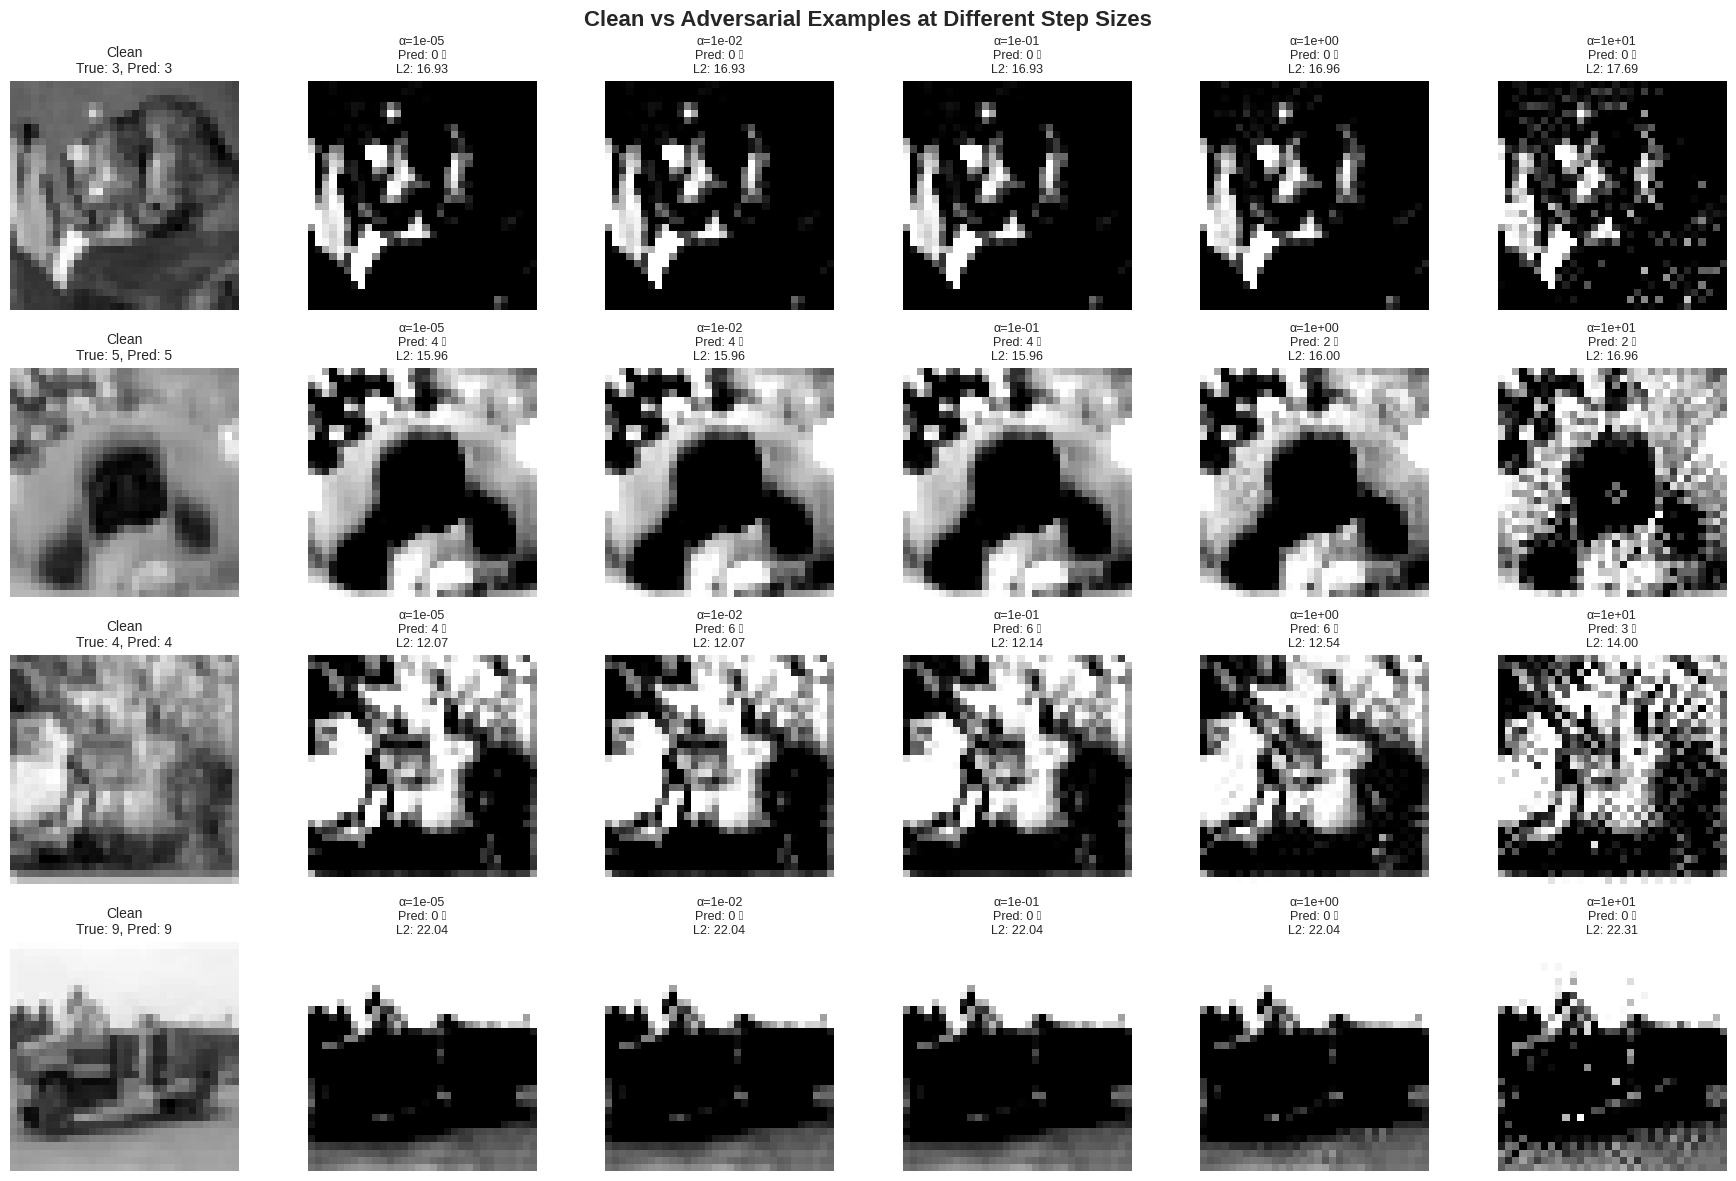

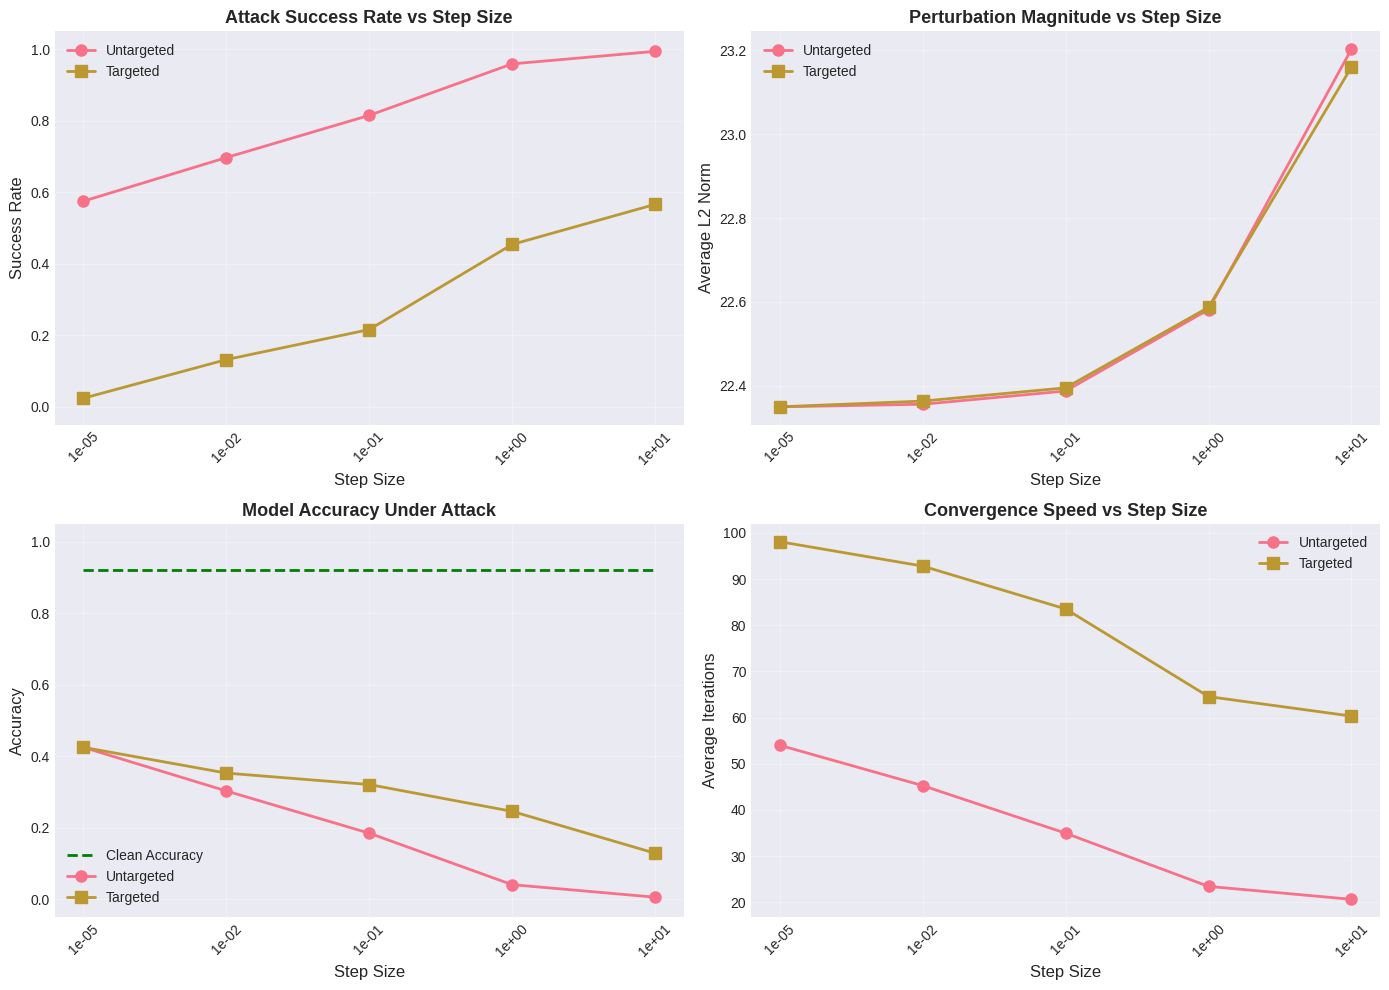

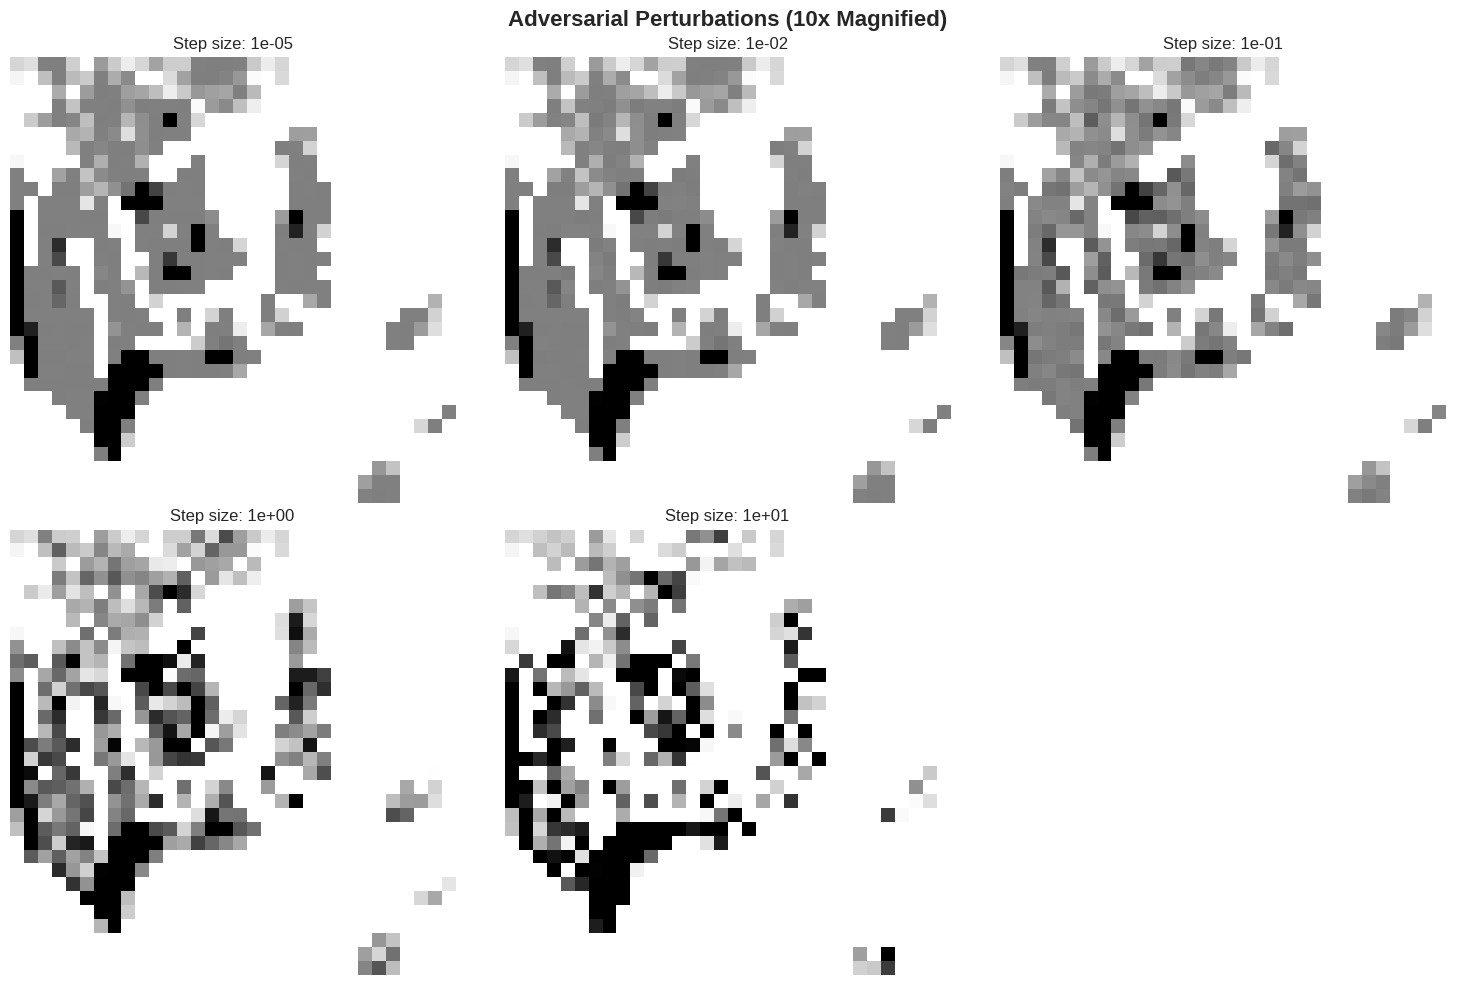

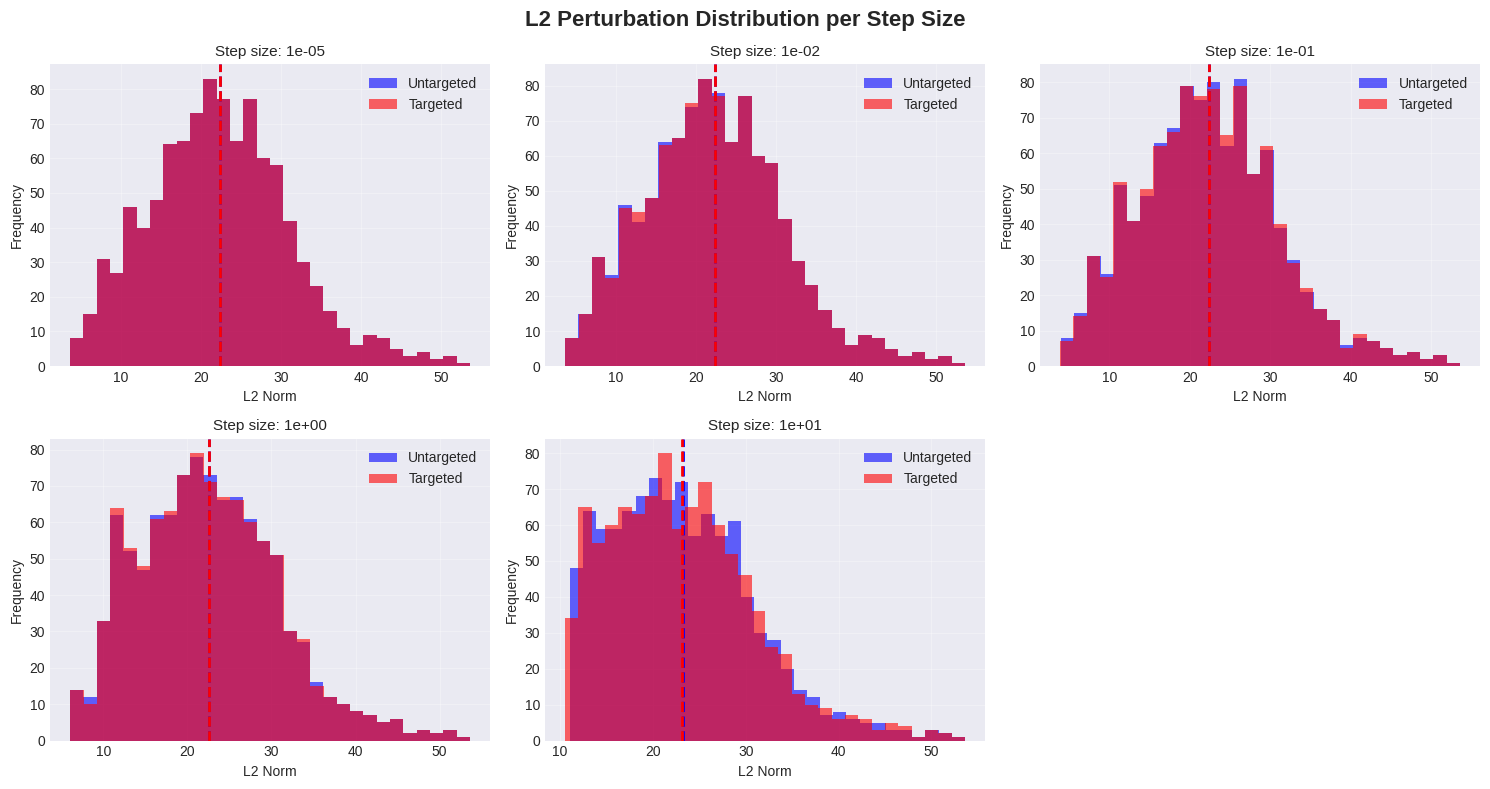

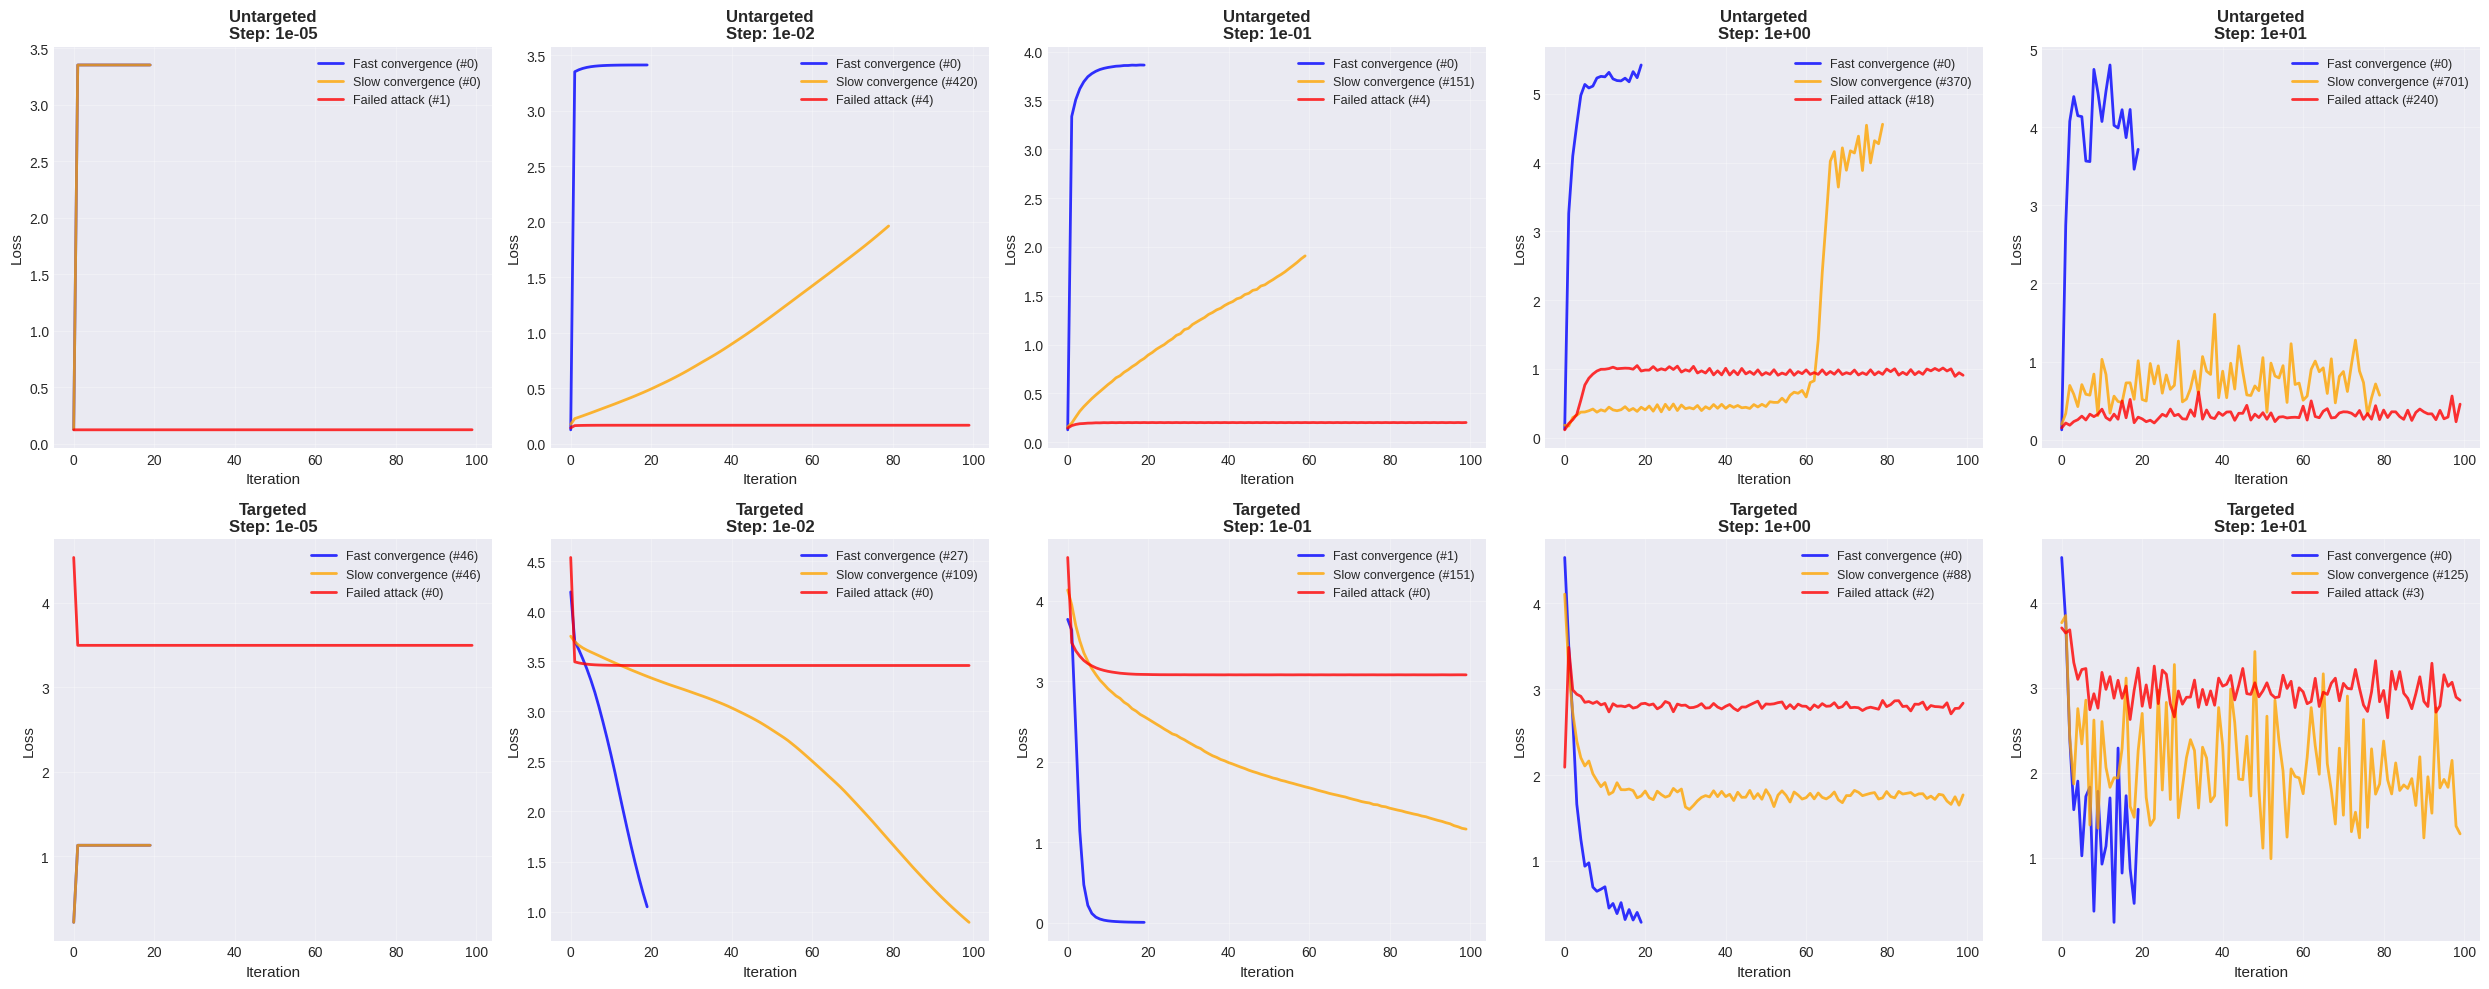


Optimal Untargeted Attack:
  Step size: 1e+01
  Success rate: 99.40%
  Accuracy drop: 91.50%
  Avg L2 norm: 23.202
  Avg iterations: 20.6

Optimal Targeted Attack:
  Step size: 1e+01
  Success rate: 56.60%
  Accuracy drop: 79.20%
  Avg L2 norm: 23.160
  Avg iterations: 60.3


In [ ]:
def evaluate_and_visualize_attacks(attack_results, model, device, save_dir='./'):
    """
    Evaluate adversarial attack performance and generate visualisations.

    Output:
    - Performance tables (success rates, accuracy drops, L2 norms)
    - Side-by-side clean vs adversarial comparisons
    - Attack metrics plots (success rate, L2 norm, accuracy, iterations)
    - Perturbation visualizations (10x magnified)
    - L2 distribution histograms
    - Loss convergence trajectories"""

    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True)

    model.eval()
    step_sizes = attack_results['step_sizes']
    clean_images = attack_results['clean_images'].to(device)
    true_labels = attack_results['true_labels'].to(device)

    # Compute baseline accuracy on clean images
    with torch.no_grad():
        clean_preds = model(clean_images).argmax(dim=1)
        clean_accuracy = (clean_preds == true_labels).float().mean().item()

    print(f"\nClean Accuracy: {clean_accuracy:.2%}")

    # Evaluate untargeted attack performance across all step sizes
    print("\nUntargeted Attack Performance:")
    print(f"{'Step Size':<12} {'Adv Accuracy':<15} {'Accuracy Drop':<15} {'Success Rate':<15}")
    print("-" * 60)

    untargeted_accuracies = {}
    for step_size in step_sizes:
        adv_images = attack_results['untargeted'][step_size]['adversarial_images'].to(device)
        with torch.no_grad():
            adv_preds = model(adv_images).argmax(dim=1)
            adv_accuracy = (adv_preds == true_labels).float().mean().item()

        accuracy_drop = clean_accuracy - adv_accuracy
        success_rate = attack_results['untargeted'][step_size]['success_rate']
        untargeted_accuracies[step_size] = adv_accuracy

        print(f"{step_size:<12.0e} {adv_accuracy:<15.2%} {accuracy_drop:<15.2%} {success_rate:<15.2%}")

    # Evaluate targeted attack performance across all step size
    print("\nTargeted Attack Performance:")
    print(f"{'Step Size':<12} {'Adv Accuracy':<15} {'Accuracy Drop':<15} {'Success Rate':<15}")
    print("-" * 60)

    targeted_accuracies = {}
    for step_size in step_sizes:
        adv_images = attack_results['targeted'][step_size]['adversarial_images'].to(device)
        with torch.no_grad():
            adv_preds = model(adv_images).argmax(dim=1)
            adv_accuracy = (adv_preds == true_labels).float().mean().item()

        accuracy_drop = clean_accuracy - adv_accuracy
        success_rate = attack_results['targeted'][step_size]['success_rate']
        targeted_accuracies[step_size] = adv_accuracy

        print(f"{step_size:<12.0e} {adv_accuracy:<15.2%} {accuracy_drop:<15.2%} {success_rate:<15.2%}")

    # Report L2 perturbation statistics for untargeted attacks
    print("\nUntargeted Attack L2 Norms:")
    print(f"{'Step Size':<12} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Median':<10}")
    print("-" * 60)

    for step_size in step_sizes:
        l2_norms = attack_results['untargeted'][step_size]['l2_norms']
        print(f"{step_size:<12.0e} {np.mean(l2_norms):<10.3f} {np.std(l2_norms):<10.3f} "
              f"{np.min(l2_norms):<10.3f} {np.max(l2_norms):<10.3f} {np.median(l2_norms):<10.3f}")

    print("\nTargeted Attack L2 Norms:")
    print(f"{'Step Size':<12} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Median':<10}")
    print("-" * 60)

    # Report L2 perturbation statistics for targeted attacks
    for step_size in step_sizes:
        l2_norms = attack_results['targeted'][step_size]['l2_norms']
        print(f"{step_size:<12.0e} {np.mean(l2_norms):<10.3f} {np.std(l2_norms):<10.3f} "
              f"{np.min(l2_norms):<10.3f} {np.max(l2_norms):<10.3f} {np.median(l2_norms):<10.3f}")

    # Visualisation 1: Side-by-side comparison of clean vs adversarial images
    # Shows visual imperceptibility by displaying 4 sample images across all step sizes
    n_steps = len(step_sizes)
    fig, axes = plt.subplots(4, n_steps + 1, figsize=(3 * (n_steps + 1), 12))
    fig.suptitle('Clean vs Adversarial Examples at Different Step Sizes', fontsize=16, fontweight='bold')

    sample_indices = [0, 25, 50, 75]

    for row, idx in enumerate(sample_indices):
        # Normalise clean image for display
        clean_img = clean_images[idx].cpu().squeeze().numpy()
        clean_img = (clean_img - clean_img.min()) / (clean_img.max() - clean_img.min() + 1e-8)

        with torch.no_grad():
            clean_pred = model(clean_images[idx:idx+1]).argmax().item()
            true_label = true_labels[idx].item()

        axes[row, 0].imshow(clean_img, cmap='gray')
        axes[row, 0].set_title(f'Clean\nTrue: {true_label}, Pred: {clean_pred}', fontsize=10)
        axes[row, 0].axis('off')

        # Display adversarial version for each step size
        for col, step_size in enumerate(step_sizes):
            adv_img = attack_results['untargeted'][step_size]['adversarial_images'][idx].cpu().squeeze().numpy()
            adv_img = (adv_img - adv_img.min()) / (adv_img.max() - adv_img.min() + 1e-8)

            with torch.no_grad():
                adv_pred = model(attack_results['untargeted'][step_size]['adversarial_images'][idx:idx+1].to(device)).argmax().item()

            l2 = attack_results['untargeted'][step_size]['l2_norms'][idx]
            success = '✓' if adv_pred != true_label else '✗'

            axes[row, col+1].imshow(adv_img, cmap='gray')
            axes[row, col+1].set_title(f'α={step_size:.0e}\nPred: {adv_pred} {success}\nL2: {l2:.2f}', fontsize=9)
            axes[row, col+1].axis('off')

    plt.tight_layout()
    plt.savefig(save_dir / 'adversarial_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualisation 2: Attack performance metrics across step sizes
    # Four subplots showing success rate, L2 norm, accuracy, and convergence speed
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Attack success rate vs step size
    untargeted_sr = [attack_results['untargeted'][s]['success_rate'] for s in step_sizes]
    targeted_sr = [attack_results['targeted'][s]['success_rate'] for s in step_sizes]

    axes[0, 0].plot(range(len(step_sizes)), untargeted_sr, 'o-', label='Untargeted', linewidth=2, markersize=8)
    axes[0, 0].plot(range(len(step_sizes)), targeted_sr, 's-', label='Targeted', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Step Size', fontsize=12)
    axes[0, 0].set_ylabel('Success Rate', fontsize=12)
    axes[0, 0].set_title('Attack Success Rate vs Step Size', fontsize=13, fontweight='bold')
    axes[0, 0].set_xticks(range(len(step_sizes)))
    axes[0, 0].set_xticklabels([f'{s:.0e}' for s in step_sizes], rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].set_ylim([-0.05, 1.05])

    # Plot 2: Average L2 perturbation magnitude vs step size
    untargeted_l2 = [np.mean(attack_results['untargeted'][s]['l2_norms']) for s in step_sizes]
    targeted_l2 = [np.mean(attack_results['targeted'][s]['l2_norms']) for s in step_sizes]

    axes[0, 1].plot(range(len(step_sizes)), untargeted_l2, 'o-', label='Untargeted', linewidth=2, markersize=8)
    axes[0, 1].plot(range(len(step_sizes)), targeted_l2, 's-', label='Targeted', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Step Size', fontsize=12)
    axes[0, 1].set_ylabel('Average L2 Norm', fontsize=12)
    axes[0, 1].set_title('Perturbation Magnitude vs Step Size', fontsize=13, fontweight='bold')
    axes[0, 1].set_xticks(range(len(step_sizes)))
    axes[0, 1].set_xticklabels([f'{s:.0e}' for s in step_sizes], rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Plot 3: Model accuracy degradation under attack
    untargeted_acc = [untargeted_accuracies[s] for s in step_sizes]
    targeted_acc = [targeted_accuracies[s] for s in step_sizes]

    axes[1, 0].plot(range(len(step_sizes)), [clean_accuracy]*len(step_sizes), '--',
                    label='Clean Accuracy', linewidth=2, color='green')
    axes[1, 0].plot(range(len(step_sizes)), untargeted_acc, 'o-', label='Untargeted', linewidth=2, markersize=8)
    axes[1, 0].plot(range(len(step_sizes)), targeted_acc, 's-', label='Targeted', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Step Size', fontsize=12)
    axes[1, 0].set_ylabel('Accuracy', fontsize=12)
    axes[1, 0].set_title('Model Accuracy Under Attack', fontsize=13, fontweight='bold')
    axes[1, 0].set_xticks(range(len(step_sizes)))
    axes[1, 0].set_xticklabels([f'{s:.0e}' for s in step_sizes], rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].set_ylim([-0.05, 1.05])

    # Plot 4: Average iterations to convergence
    untargeted_iters = [np.mean(attack_results['untargeted'][s]['iterations']) for s in step_sizes]
    targeted_iters = [np.mean(attack_results['targeted'][s]['iterations']) for s in step_sizes]

    axes[1, 1].plot(range(len(step_sizes)), untargeted_iters, 'o-', label='Untargeted', linewidth=2, markersize=8)
    axes[1, 1].plot(range(len(step_sizes)), targeted_iters, 's-', label='Targeted', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Step Size', fontsize=12)
    axes[1, 1].set_ylabel('Average Iterations', fontsize=12)
    axes[1, 1].set_title('Convergence Speed vs Step Size', fontsize=13, fontweight='bold')
    axes[1, 1].set_xticks(range(len(step_sizes)))
    axes[1, 1].set_xticklabels([f'{s:.0e}' for s in step_sizes], rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_dir / 'attack_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualisation 3: Adversarial perturbation patterns (magnified 10x)
    # Demonstrates visual imperceptibility by showing perturbations are invisible at normal scale
    n_cols = min(3, len(step_sizes))
    n_cols = min(3, len(step_sizes))
    n_rows = (len(step_sizes) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle('Adversarial Perturbations (10x Magnified)', fontsize=16, fontweight='bold')

    idx = 0
    for i, step_size in enumerate(step_sizes):
        row, col = i // n_cols, i % n_cols

        clean = clean_images[idx].cpu()
        adv = attack_results['untargeted'][step_size]['adversarial_images'][idx]

        # Compute and magnify perturbation for visibility
        noise = (adv - clean).squeeze().numpy()
        noise = noise * 10
        noise = np.clip(noise, -1, 1)
        noise = (noise + 1) / 2

        axes[row, col].imshow(noise, cmap='gray')
        axes[row, col].set_title(f'Step size: {step_size:.0e}', fontsize=12)
        axes[row, col].axis('off')

    for i in range(len(step_sizes), n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig(save_dir / 'perturbation_noise.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualisation 4: L2 norm distribution histograms
    # Shows perturbation magnitude variance across samples for each step size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle('L2 Perturbation Distribution per Step Size', fontsize=16, fontweight='bold')

    for i, step_size in enumerate(step_sizes):
        row, col = i // n_cols, i % n_cols

        untargeted_l2_dist = attack_results['untargeted'][step_size]['l2_norms']
        targeted_l2_dist = attack_results['targeted'][step_size]['l2_norms']

        axes[row, col].hist(untargeted_l2_dist, bins=30, alpha=0.6, label='Untargeted', color='blue')
        axes[row, col].hist(targeted_l2_dist, bins=30, alpha=0.6, label='Targeted', color='red')
        axes[row, col].axvline(np.mean(untargeted_l2_dist), color='blue', linestyle='--', linewidth=2)
        axes[row, col].axvline(np.mean(targeted_l2_dist), color='red', linestyle='--', linewidth=2)
        axes[row, col].set_xlabel('L2 Norm', fontsize=10)
        axes[row, col].set_ylabel('Frequency', fontsize=10)
        axes[row, col].set_title(f'Step size: {step_size:.0e}', fontsize=11)
        axes[row, col].legend()
        axes[row, col].grid(alpha=0.3)

    for i in range(len(step_sizes), n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig(save_dir / 'l2_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualisation 5: Loss convergence trajectories
    # Shows optimization dynamics by plotting loss vs iteration for representative samples
    fig, axes = plt.subplots(2, len(step_sizes), figsize=(5 * len(step_sizes), 10))
    if len(step_sizes) == 1:
        axes = axes.reshape(2, 1)

    for i, step_size in enumerate(step_sizes):
        # Untargeted loss convergence
        iters = np.array(attack_results['untargeted'][step_size]['iterations'])
        success = np.array(attack_results['untargeted'][step_size]['success'])
        loss_histories = attack_results['untargeted'][step_size]['loss_histories']

        # Select representative samples: fastest, slowest, and failed attacks
        success_indices = np.where(success)[0]
        samples_to_plot = []

        if len(success_indices) > 0:
            fast_idx = success_indices[np.argmin(iters[success_indices])]
            slow_idx = success_indices[np.argmax(iters[success_indices])]
            samples_to_plot.extend([
                ('Fast convergence', fast_idx, 'blue'),
                ('Slow convergence', slow_idx, 'orange')
            ])

        fail_indices = np.where(~success)[0]
        if len(fail_indices) > 0:
            failed_idx = fail_indices[0]
            samples_to_plot.append(('Failed attack', failed_idx, 'red'))

        # Plot untargeted
        for label, idx, color in samples_to_plot:
            loss_hist = loss_histories[idx]
            axes[0, i].plot(loss_hist, label=f'{label} (#{idx})',
                           linewidth=2, alpha=0.8, color=color)

        axes[0, i].set_xlabel('Iteration', fontsize=11)
        axes[0, i].set_ylabel('Loss', fontsize=11)
        axes[0, i].set_title(f'Untargeted\nStep: {step_size:.0e}', fontsize=12, fontweight='bold')
        axes[0, i].legend(fontsize=9)
        axes[0, i].grid(alpha=0.3)

        # Targeted loss convergence
        iters_tgt = np.array(attack_results['targeted'][step_size]['iterations'])
        success_tgt = np.array(attack_results['targeted'][step_size]['success'])
        loss_histories_tgt = attack_results['targeted'][step_size]['loss_histories']

        success_indices_tgt = np.where(success_tgt)[0]
        samples_to_plot_tgt = []

        if len(success_indices_tgt) > 0:
            fast_idx_tgt = success_indices_tgt[np.argmin(iters_tgt[success_indices_tgt])]
            slow_idx_tgt = success_indices_tgt[np.argmax(iters_tgt[success_indices_tgt])]
            samples_to_plot_tgt.extend([
                ('Fast convergence', fast_idx_tgt, 'blue'),
                ('Slow convergence', slow_idx_tgt, 'orange')
            ])

        fail_indices_tgt = np.where(~success_tgt)[0]
        if len(fail_indices_tgt) > 0:
            failed_idx_tgt = fail_indices_tgt[0]
            samples_to_plot_tgt.append(('Failed attack', failed_idx_tgt, 'red'))

        for label, idx, color in samples_to_plot_tgt:
            loss_hist = loss_histories_tgt[idx]
            axes[1, i].plot(loss_hist, label=f'{label} (#{idx})',
                           linewidth=2, alpha=0.8, color=color)

        axes[1, i].set_xlabel('Iteration', fontsize=11)
        axes[1, i].set_ylabel('Loss', fontsize=11)
        axes[1, i].set_title(f'Targeted\nStep: {step_size:.0e}', fontsize=12, fontweight='bold')
        axes[1, i].legend(fontsize=9)
        axes[1, i].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_dir / 'loss_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()

    best_unt_step = max(step_sizes, key=lambda s: attack_results['untargeted'][s]['success_rate'])
    best_tgt_step = max(step_sizes, key=lambda s: attack_results['targeted'][s]['success_rate'])

    # Identify optimal attack configurations
    print(f"\nOptimal Untargeted Attack:")
    print(f"  Step size: {best_unt_step:.0e}")
    print(f"  Success rate: {attack_results['untargeted'][best_unt_step]['success_rate']:.2%}")
    print(f"  Accuracy drop: {(clean_accuracy - untargeted_accuracies[best_unt_step]):.2%}")
    print(f"  Avg L2 norm: {np.mean(attack_results['untargeted'][best_unt_step]['l2_norms']):.3f}")
    print(f"  Avg iterations: {np.mean(attack_results['untargeted'][best_unt_step]['iterations']):.1f}")

    print(f"\nOptimal Targeted Attack:")
    print(f"  Step size: {best_tgt_step:.0e}")
    print(f"  Success rate: {attack_results['targeted'][best_tgt_step]['success_rate']:.2%}")
    print(f"  Accuracy drop: {(clean_accuracy - targeted_accuracies[best_tgt_step]):.2%}")
    print(f"  Avg L2 norm: {np.mean(attack_results['targeted'][best_tgt_step]['l2_norms']):.3f}")
    print(f"  Avg iterations: {np.mean(attack_results['targeted'][best_tgt_step]['iterations']):.1f}")

    return {
        'clean_accuracy': clean_accuracy,
        'untargeted_accuracies': untargeted_accuracies,
        'targeted_accuracies': targeted_accuracies
    }

# Evaluate attack performance and generate all visualizations
evaluation_metrics = evaluate_and_visualize_attacks(
    adversarial_attack_results,
    pretrained_model,
    DEVICE,
    save_dir=RESULTS_DIR
)

## Loss convergence analysis: Convergence patterns across step sizes

**Untargeted attacks**:
- **Small step sizes (1e-05, 1e-02)**: Gradual monotonic loss increase, indicating stable but slow optimisation. Fast convergence samples reach attack objectives efficiently, while slow convergence samples require full 100 iterations.
- **Medium step size (1e-01)**: Steeper loss trajectories with faster convergence. Most samples achieve attack objectives within 60-80 iterations.
- **Large step sizes (1e+00, 1e+01)**: Highly volatile loss dynamics.

**Targeted attacks**:
- **Small step sizes**: Flat or slowly decreasing loss, indicating difficulty navigating toward the specific target class (Class 5).
- **Medium to large step sizes**: Sharp initial loss drops followed by either stabilisation (successful targeted attack) or plateau (failed targeting).

**Key Insight**: Attack success depends more on optimisation trajectory (how effectively step sizes navigate the loss landscape) than perturbation magnitude, explaining why L2 norms remain stable across most step sizes while success rates vary dramatically (7.2% to 99.4% for untargeted).

## Adversarial perturbation visualization analysis (10x magnified)

Perturbations appear visually similar across these step sizes when magnified, with the structural features remaining sharp and well-defined. This visual similarity corresponds to the stable average L2 norms, confirming that these step sizes produce similar perturbation magnitudes despite achieving different attack success rates.

**Blue Team defence testing: Anomaly and OOD detection.**



In [ ]:
# Defence Testing
print("\n" + "=" * 70)
print(f"Defence Testing - Epsilon: {best_epsilon}")
print("=" * 70)

# Store results for summary table
defense_results = {}

for step_size in step_sizes:
    adv_images_unt = adversarial_attack_results['untargeted'][step_size]['adversarial_images'].to(DEVICE)
    unt_success = adversarial_attack_results['untargeted'][step_size]['success_rate']
    tgt_success = adversarial_attack_results['targeted'][step_size]['success_rate']

    # OCSVM
    ocsvm_features = extract_features_for_ocsvm(adv_images_unt, pretrained_model)
    ocsvm_predictions = ocsvm_model.predict(ocsvm_features)
    ocsvm_evasion = (ocsvm_predictions == 1).sum() / len(ocsvm_predictions)

    # VAE
    with torch.no_grad():
        adv_flat = adv_images_unt.view(len(adv_images_unt), -1)
        adv_normalized = []
        for i in range(len(adv_flat)):
            sample = adv_flat[i]
            sample_norm = (sample - sample.min()) / (sample.max() - sample.min() + 1e-8)
            adv_normalized.append(sample_norm)
        adv_normalized = torch.stack(adv_normalized)

        vae_recon, _, _ = vae(adv_normalized)
        mse = F.mse_loss(vae_recon, adv_normalized, reduction='none')
        mse_per_sample = mse.view(len(adv_images_unt), -1).mean(dim=1)
        vae_evasion = (mse_per_sample <= vae_threshold).sum().item() / len(adv_images_unt)

    # Mahalanobis
    with torch.no_grad():
        features_list = []
        for img in adv_images_unt:
            if img.dim() == 3:
                img = img.unsqueeze(0)
            x = pretrained_model.model.conv1(img)
            x = pretrained_model.model.conv2(x)
            x = pretrained_model.model.conv3(x)
            x = x + pretrained_model.model.conv5(pretrained_model.model.conv4(x))
            x = pretrained_model.model.conv6(x)
            x = pretrained_model.model.conv7(x)
            x = x + pretrained_model.model.conv9(pretrained_model.model.conv8(x))
            x = pretrained_model.model.pool10(x)
            features_list.append(x.flatten())

        features = torch.stack(features_list)
        distances = compute_mahalanobis_distances(features)

        if auroc_test < 0.5:
            distances = -distances

        # Low distance = in-distribution (evades detection)
        # High distance = OOD (detected)
        # Evasion = samples with distance <= threshold (classified as in-distribution)
        maha_evasion = (distances <= optimal_maha_threshold).sum().item() / len(adv_images_unt)

    defense_results[step_size] = {
        'unt_success': unt_success,
        'tgt_success': tgt_success,
        'ocsvm_evasion': ocsvm_evasion,
        'vae_evasion': vae_evasion,
        'maha_evasion': maha_evasion
    }

# Print summary table
print(f"\n{'Step':<10} {'Unt Succ':<10} {'Tgt Succ':<10} {'OCSVM Ev':<10} {'VAE Ev':<10} {'Maha Ev':<10}")
print("-" * 70)
for step_size in step_sizes:
    r = defense_results[step_size]
    print(f"{step_size:<10.0e} {r['unt_success']:<10.1%} {r['tgt_success']:<10.1%} "
          f"{r['ocsvm_evasion']:<10.1%} {r['vae_evasion']:<10.1%} {r['maha_evasion']:<10.1%}")


Defence Testing - Epsilon: 12.0

Step       Unt Succ   Tgt Succ   OCSVM Ev   VAE Ev     Maha Ev   
----------------------------------------------------------------------
1e-05      57.5%      2.4%       26.5%      5.5%       20.9%     
1e-02      69.7%      13.2%      26.0%      5.5%       18.9%     
1e-01      81.5%      21.6%      34.1%      5.6%       16.8%     
1e+00      95.9%      45.4%      48.3%      4.8%       18.9%     
1e+01      99.4%      56.6%      8.2%       3.0%       46.4%     
